# Dedispersion

By J. W. Kania

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
height = 256 # height of plot
width = height*(8+2) # width of the plot, 8 heights + 2 heights pad 
noise = np.random.normal(size=[256,width]) # guassian noise as background
dispersed=np.zeros((256,width))# will hold noise + pulses
de_dispersed=np.zeros((256,width))
coherent=np.zeros((256,width))

In [3]:
def pulse(array, freq_bin, DM=0.004, offset=32, spacing=640, a=10, c=7):
    """
    Addes four quadratic pulses to an array, sweeps quadratically in frequency 
    
    Arguments:
    ---
    array: frequency chunck to add pulse to
    
    freq_bin: Frequency number to which pulse added
    
    Keyword Arguments:
    ---
    DM: the Dispersion Measure of the pulse
    
    offset: offset of first pulse from the left hand side
    
    spacing: spaces between the four pulses
    
    a: heigt of injected pulse
    
    c: width of injected pulse
    
    Returns: array with four guassian pulses
    """
    arg = np.linspace(0,width, width)-offset # the x in the gussian 
    freq_bin+=64 # offset, the plot starts at a finite freq
    return array + a*(np.exp(-(arg-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg-spacing-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg-2*spacing-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg-3*spacing-DM*freq_bin**2)**2/(2.*c**2)))

In [4]:
DM = 0.004 # The Dispersion Messure of the pulse
offset = 32 # offset of the first pulse from the rhs
spacing = 640 # spaces between pulses

In [5]:
for fbin in range(0,height): #loop over noise array, injecting the pulses
    dispersed[fbin,:] = pulse(noise[fbin,:],fbin, DM=DM, offset=offset, spacing=spacing)

We can see the dispersed pulses

Text(0, 0.5, 'Frequency')

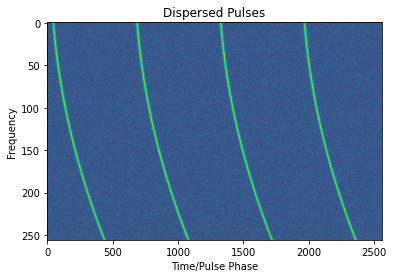

In [6]:
plt.imshow(dispersed, aspect='auto')
plt.title('Dispersed Pulses')
plt.xlabel('Time/Pulse Phase')
plt.ylabel('Frequency')

Above we see the pulses in the Frequency time plot. Integrating all the frequencies, we get at time series

Text(0, 0.5, 'Amplitude')

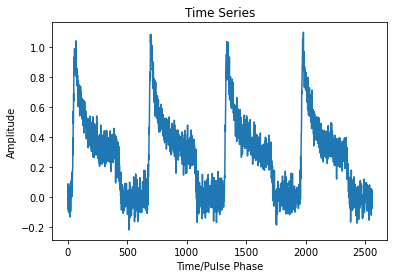

In [7]:
plt.plot(dispersed.mean(axis=0))
plt.title('Time Series')
plt.xlabel('Time/Pulse Phase')
plt.ylabel('Amplitude')

We see that the pulse's power is spread out by dispersion. We want to see the the pulse as it actually is. We also want the pulse to be as bright as possable, compaired to the noise. We do this, we will dedisperse the frequency time data. The easiest way to do this is move channels of data in time, called incoherent Dedispersion.

## Incoherent Dedispersion aligns blocks of freq-time space

In [8]:
nchans = 4 # define the number of channels we want

In [9]:
def dedisp_pulse(array, freq_bin, nchans, DM=0.004, offset=32, spacing=640, a=10, c=7):
    """
    Addes channalized quadratic pulses to an array, aligns center of each channel 
    
    Arguments:
    ---
    array: frequency chunck to add pulse to
    
    freq_bin: Frequency number to which pulse added
    
    nchans: number of channels
    
    Keyword Arguments:
    ---
    DM: the Dispersion Measure of the pulse
    
    offset: offset of first pulse from the left hand side
    
    spacing: spaces between the four pulses
    
    a: heigt of injected pulse
    
    c: width of injected pulse
    
    Returns: array with four guassian pulses
    """
    arg = np.linspace(0,width, width)-offset
    freq_bin+=64 # offset, the plot starts at a finite freq
    bin_per_chan = height//nchans
    channelizer =  bin_per_chan*(freq_bin//bin_per_chan)+bin_per_chan//2 
    # Group freq bin into channels
    delay = DM*(channelizer**2-(height+bin_per_chan//2)**2)
    # Delay to move center channel
    # print(DM*channelizer**2,delay)
    return array + a*(np.exp(-(arg+delay-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-spacing-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-2*spacing-DM*freq_bin**2)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-3*spacing-DM*freq_bin**2)**2/(2.*c**2)))

In [10]:
for fbin in range(0,height): # inject incoherent dedispersed pulse
    de_dispersed[fbin,:] = dedisp_pulse(noise[fbin,:], fbin, nchans, DM=DM, spacing=spacing, offset=offset)

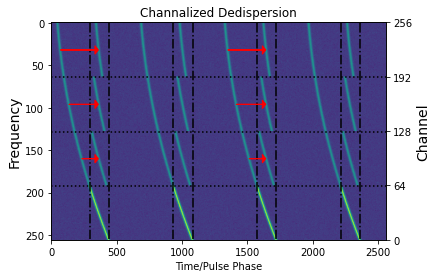

In [11]:
plt.imshow(de_dispersed+dispersed-noise, aspect='auto')

for chan_edge in range(height//nchans,height,height//nchans):
    plt.hlines(chan_edge,0,width-1,linestyles=':')
for j in range(0, nchans):
    plt.vlines(j*spacing+offset+DM*(height)**2,0,height-1,linestyles='-.')
    plt.vlines(j*spacing+offset+DM*(height+height//nchans)**2,0,height-1,linestyles='-.')

arrow_shortner = 30 # makes arrows look nice
time_center_top_chan = DM*(height-height//(2*nchans)+64)**2+offset# we started the channels @ 64, need to add this back
for k in range(0, nchans-1):
    center_chan = k*height//nchans+height//(2*nchans)
    center_time = DM*(center_chan+64)**2+offset 
    # we started the channels @ 64, need to add this
    plt.arrow(center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)
    plt.arrow(2*spacing+center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)

plt.title('Channalized Dedispersion')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Time/Pulse Phase')
ax21 = plt.twinx()
ax21.set_ylabel('Channel', fontsize=14)
ax21.set_yticks(range(0, height+1, height//nchans))

We see that the channels are now aligned in frequency time space, but there is still smearing within each channel. 

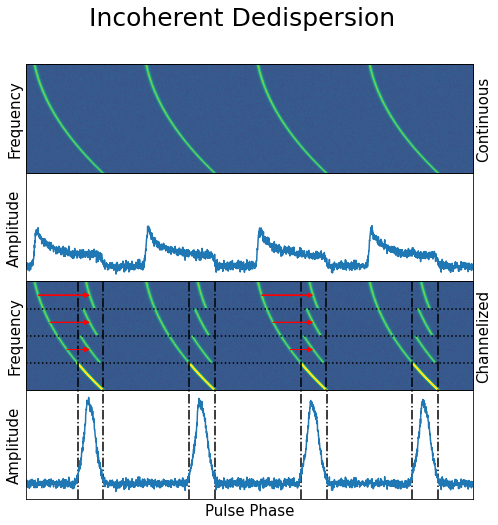

In [12]:
label_size = 15 # label font size 
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,figsize=(8,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Incoherent Dedispersion',fontsize=25)

# dispersed plot
disp_im = ax0.imshow(dispersed, aspect='auto')
ax0.set_ylabel('Frequency', fontsize=label_size)
ax01 = ax0.twinx()
ax01.set_ylabel('Continuous', fontsize=label_size)

clim_disp=disp_im.properties()['clim'] # set the levels for all the plots

# time series of dispered signal
ax1.plot(dispersed.mean(axis=0))
ax1.margins(x=0)
ax1.set_ylabel('Amplitude', fontsize=label_size)
max_value = np.amax(de_dispersed.mean(axis=0))+0.2 # set y extent for dedispersed signal
min_value = np.amin(de_dispersed.mean(axis=0))-0.2
ax1.set_ylim(min_value, max_value)

# original signal channelized dedispersion 
ax2.imshow(de_dispersed+dispersed-noise,aspect='auto',clim=clim_disp)
# add the dedispersed signal and dispersed sigal to compare
# each has a copy of the noise, so subtract the nosie off

for chan_edge in range(height//nchans,height,height//nchans):
    ax2.hlines(chan_edge,0,width-1,linestyles=':')
for j in range(0, nchans):
    ax2.vlines(j*spacing+offset+DM*(height)**2,0,height-1,linestyles='-.')
    ax2.vlines(j*spacing+offset+DM*(height+height//nchans)**2,0,height-1,linestyles='-.')
    
arrow_shortner = 30 # makes arrows look nice
time_center_top_chan = DM*(height-height//(2*nchans)+64)**2+offset# we started the channels @ 64, need to add this back
for k in range(0, nchans-1):
    center_chan = k*height//nchans+height//(2*nchans)
    center_time = DM*(center_chan+64)**2+offset 
    # we started the channels @ 64, need to add this
    ax2.arrow(center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)
    ax2.arrow(2*spacing+center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)

ax2.set_ylabel('Frequency', fontsize=label_size)
ax21 = ax2.twinx()
ax21.set_ylabel('Channelized', fontsize=label_size)

# incoherently dedispersed timeseries
ax3.plot(de_dispersed.mean(axis=0))
ax3.margins(x=0)
ax3.set_ylabel('Amplitude', fontsize=label_size)
ax3.set_xlabel('Pulse Phase', fontsize=label_size)
ax3.set_ylim(min_value, max_value)

# place verticle lines at time locations of the last channel's first at last freq bin
for k in range(0, nchans):
    ax3.vlines(spacing*k+offset+DM*(height+64)**2,min_value,max_value,linestyles='-.')
    ax3.vlines(spacing*k+offset+DM*(height-height/nchans+64)**2,min_value,max_value,linestyles='-.')

# get rid of the ticks
for ax in (ax0,ax1,ax2,ax3,ax01,ax21):
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('Incoherent_Dedispersion.png', dpi=400)

Incoherent dedispersion removes some off the despersion effects, and puts the pulse energy in fewer bins. We are still sufferning from interchannel smearing. We can covercome this my using coherent dedispersion. This will perfectly remove the effects of dispersion.

## Coherent Dedispersion can perfectly remove the interchannel smearing

In [13]:
def no_disp_pulse(array, freq_bin, DM=0.004, offset=32, spacing=640, a=10, c=7):
    """
    Addes undispersed pulses to an array, aligns center of each channel 
    
    Arguments:
    ---
    array: frequency chunck to add pulse to
    
    freq_bin: Frequency number to which pulse added
    
    Keyword Arguments:
    ---
    DM: the Dispersion Measure of the pulse (to center the pulse wrt the other plot)
    
    offset: offset of first pulse from the left hand side
    
    spacing: spaces between the four pulses
    
    a: heigt of injected pulse
    
    c: width of injected pulse
    
    Returns: array with four guassian pulses
    """
    arg = np.linspace(0,width, width)-offset
    freq_bin+=64 # offset, the plot starts at a finite freq
    #bin_per_chan = height//nchans
    #channelizer =  bin_per_chan*(freq_bin//bin_per_chan)+bin_per_chan//2 
    # Group freq bin into channels
    delay = DM*(-(height-height//(2*nchans)+64)**2)
    # Delay to move center channel
    # print(DM*channelizer**2,delay)
    return array + a*(np.exp(-(arg+delay)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-spacing)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-2*spacing)**2/(2.*c**2))+\
                      np.exp(-(arg+delay-3*spacing)**2/(2.*c**2)))

In [14]:
for j in range(0,256):
    coherent[j,:] = no_disp_pulse(noise[j,:],j)

Text(0.5, 0, 'Time/Pulse Phase')

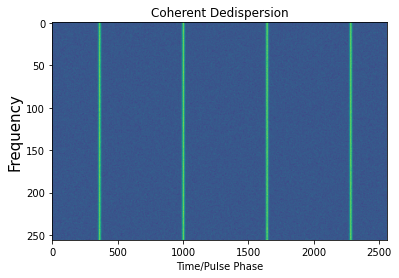

In [15]:
plt.imshow(coherent, aspect='auto')
plt.title('Coherent Dedispersion')
plt.ylabel('Frequency', fontsize=label_size)
plt.xlabel('Time/Pulse Phase')

Here we have a frequency time image with no dispersion. 

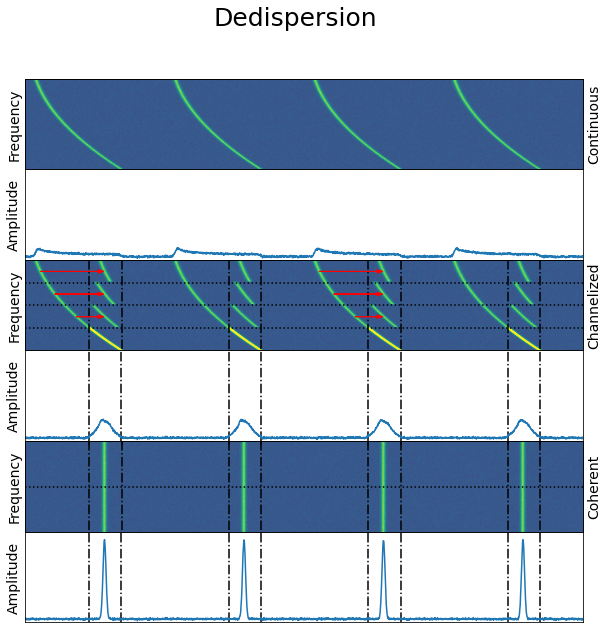

In [16]:
label_size = 14 # label font size 
fig, (ax0,ax1,ax2,ax3, ax4, ax5) = plt.subplots(6,figsize=(10,10))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Dedispersion',fontsize=25)

# dispersed plot
disp_im = ax0.imshow(dispersed, aspect='auto')
ax0.set_ylabel('Frequency', fontsize=label_size)
ax01 = ax0.twinx()
ax01.set_ylabel('Continuous', fontsize=label_size)

clim_disp=disp_im.properties()['clim'] # set the levels for all the plots

# time series of dispered signal
ax1.plot(dispersed.mean(axis=0))
ax1.margins(x=0)
ax1.set_ylabel('Amplitude', fontsize=label_size)
max_value = np.amax(coherent.mean(axis=0))+1 # set y extent for dedispersed signal
min_value = np.amin(coherent.mean(axis=0))-0.2
ax1.set_ylim(min_value, max_value)

# original signal channelized dedispersion 
ax2.imshow(de_dispersed+dispersed-noise,aspect='auto',clim=clim_disp)
# add the dedispersed signal and dispersed sigal to compare
# each has a copy of the noise, so subtract the nosie off

for chan_edge in range(height//nchans,height,height//nchans):
    ax2.hlines(chan_edge,0,width-1,linestyles=':')
for j in range(0, nchans):
    ax2.vlines(j*spacing+offset+DM*(height)**2,0,height-1,linestyles='-.')
    ax2.vlines(j*spacing+offset+DM*(height+height//nchans)**2,0,height-1,linestyles='-.')
    
arrow_shortner = 30 # makes arrows look nice
time_center_top_chan = DM*(height-height//(2*nchans)+64)**2+offset# we started the channels @ 64, need to add this back
for k in range(0, nchans-1):
    center_chan = k*height//nchans+height//(2*nchans)
    center_time = DM*(center_chan+64)**2+offset 
    # we started the channels @ 64, need to add this
    ax2.arrow(center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)
    ax2.arrow(2*spacing+center_time, center_chan, time_center_top_chan-center_time-arrow_shortner,\
              0, head_width=10, head_length=27, color='r', zorder=10)

ax2.set_ylabel('Frequency', fontsize=label_size)
ax21 = ax2.twinx()
ax21.set_ylabel('Channelized', fontsize=label_size)

# incoherently dedispersed timeseries
ax3.plot(de_dispersed.mean(axis=0))
ax3.margins(x=0)
ax3.set_ylabel('Amplitude', fontsize=label_size)
ax3.set_xlabel('Pulse Phase', fontsize=label_size)
ax3.set_ylim(min_value, max_value)

# place verticle lines at time locations of the last channel's first at last freq bin
for k in range(0, nchans):
    ax3.vlines(spacing*k+offset+DM*(height+64)**2,min_value,max_value,linestyles='-.')
    ax3.vlines(spacing*k+offset+DM*(height-height/nchans+64)**2,min_value,max_value,linestyles='-.')

# Coherently dedispersed time series
ax4.imshow(coherent,aspect='auto', clim=clim_disp)
for j in range(0, nchans):
    ax4.vlines(j*spacing+offset+DM*(height)**2,0,height-1,linestyles='-.')
    ax4.vlines(j*spacing+offset+DM*(height+height//nchans)**2,0,height-1,linestyles='-.')

ax4.set_ylabel('Frequency', fontsize=label_size)
ax41 = ax4.twinx()
ax41.set_ylabel('Coherent', fontsize=label_size)
for k in range(0, nchans):
    ax4.vlines(spacing*k+offset+DM*(height+64)**2,min_value,max_value,linestyles='-.')
    ax4.vlines(spacing*k+offset+DM*(height-height/nchans+64)**2,min_value,max_value,linestyles='-.')
for chan_edge in range(2*height//nchans,height,2*height//nchans):
    ax4.hlines(chan_edge,0,width-1,linestyles=':')
    
# Coherent time series    
ax5.plot(coherent.mean(axis=0))
ax5.margins(x=0)
ax5.set_ylabel('Amplitude', fontsize=label_size)
ax5.set_ylim(min_value, max_value)
for k in range(0, nchans):
    ax5.vlines(spacing*k+offset+DM*(height+64)**2,min_value,max_value,linestyles='-.')
    ax5.vlines(spacing*k+offset+DM*(height-height/nchans+64)**2,min_value,max_value,linestyles='-.')
    
# get rid of the ticks    
for ax in (ax0, ax1, ax2, ax3, ax01, ax21, ax4, ax41, ax5):
    ax.set_xticks([])
    ax.set_yticks([]) 
    
plt.savefig('Dedispersion.png', dpi=400)

We see that the coherently dedispersed data dosen't have have any interchannel smearing. This make the pulse brighter. It also best shows the intrinsic pulse shape. Since there is not interchannel smearing, we can use less channels, reducing the data that needs to be stored. We need to the DM at the time of the observation to coherently dedisperse that data, so this method can't be used all the time.